In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from typing import List

In [2]:
DATA_DIR = "./data"

# Default columns
COL_DATE = "SETTLEMENT DATE"
COL_CUSIP = "CUSIP"
COL_SYMBOL = "SYMBOL"
COL_QUANTITY = "QUANTITY (FAILS)"
COL_DESC = "DESCRIPTION"
COL_PRICE = "PRICE"

DEFAULT_COLUMN_NAMES = [COL_DATE,
                        COL_CUSIP,
                        COL_SYMBOL,
                        COL_QUANTITY,
                        COL_DESC,
                        COL_PRICE]

# New column
COL_TOTAL = "TOTAL (USD)"

def parse_data_dir(dir_path:str) -> pd.DataFrame:
    dfs = []
    for file_name in os.listdir(dir_path):
        full_file_path = dir_path + "/" + file_name

        data = []
        parse_file(full_file_path, data)

        df = pd.DataFrame(data, columns=DEFAULT_COLUMN_NAMES)
        
        df.drop(columns=COL_DESC, inplace=True)
        
        df[COL_DATE] = pd.to_datetime(df[COL_DATE])
        df[COL_QUANTITY] = pd.to_numeric(df[COL_QUANTITY], downcast='unsigned')
        df[COL_PRICE] = pd.to_numeric(df[COL_PRICE])

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True).sort_values(by=[COL_DATE, COL_SYMBOL], ignore_index=True)

def parse_file(fpath:str, data:List[str]) -> None:
    with open(fpath, "r") as file:
        lines = file.readlines()
    
    skip_header_index = 0
    
    for i, line in enumerate(lines):
        if i == skip_header_index:
            continue
        
        # Remove NULL bytes, pd.read_csv won't work here
        line = (line
                .replace("\x00", "")
                .strip()
                .split("|"))
        
        # Skip footer lines
        if len(line) == 1:
            continue
        
        # Fix price value
        # When the price is not available or is less than a penny, the field is filled with a "."
        if (line[-1] == "."):
            line[-1] = "0"
        
        data.append(line)

df = parse_data_dir(DATA_DIR)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14706947 entries, 0 to 14706946
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   SETTLEMENT DATE   datetime64[ns]
 1   CUSIP             object        
 2   SYMBOL            object        
 3   QUANTITY (FAILS)  uint32        
 4   PRICE             float64       
dtypes: datetime64[ns](1), float64(1), object(2), uint32(1)
memory usage: 504.9+ MB


In [3]:
df.head()

,SETTLEMENT DATE,CUSIP,SYMBOL,QUANTITY (FAILS),PRICE
0,2010-01-04,00846U101,A,460,31.07
1,2010-01-04,04543P100,AACC,82,6.78
2,2010-01-04,04518D108,AAGH,881,0.00
3,2010-01-04,00949P108,AAI,1432,5.22
4,2010-01-04,05350T101,AAIR,2500,2.05


In [4]:
# Create new column for the security total FTD
df[COL_TOTAL] = df[COL_QUANTITY] * df[COL_PRICE]
df.head()

,SETTLEMENT DATE,CUSIP,SYMBOL,QUANTITY (FAILS),PRICE,TOTAL (USD)
0,2010-01-04,00846U101,A,460,31.07,14292.20
1,2010-01-04,04543P100,AACC,82,6.78,555.96
2,2010-01-04,04518D108,AAGH,881,0.00,0.00
3,2010-01-04,00949P108,AAI,1432,5.22,7475.04
4,2010-01-04,05350T101,AAIR,2500,2.05,5125.00


# Monthly Aggregations

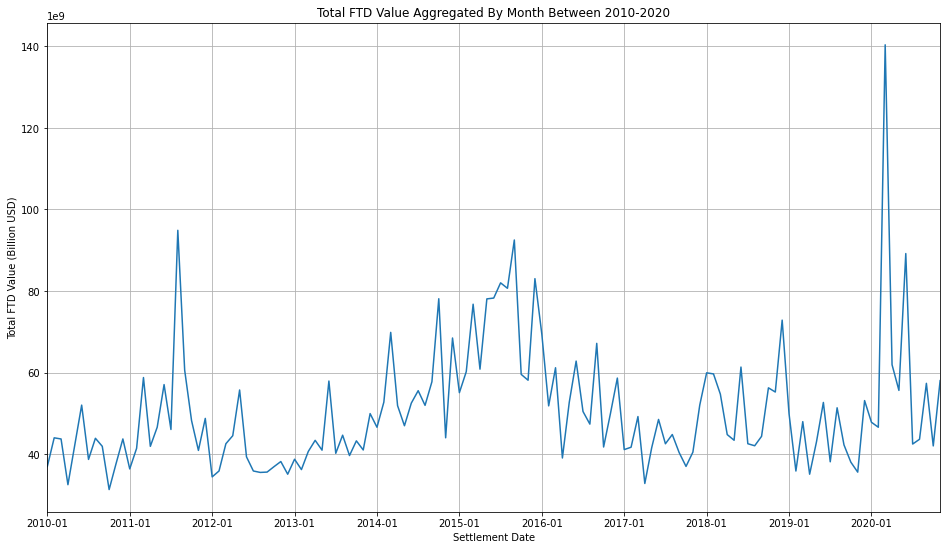

In [5]:
df1 = (df
       .groupby(by=pd.Grouper(key=COL_DATE, freq="M"))
       .agg({COL_TOTAL: sum})
       .reset_index())

plt.figure(figsize=(16, 9))

x = list(range(len(df1)))
x_labels = [f"{date:%Y-%m}" for idx, date in enumerate(df1[COL_DATE]) if idx % 12 == 0]
x_ticks = [x * 12 for x in list(range(len(x_labels)))]

plt.plot(x, df1[COL_TOTAL])
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.xlim(left=0, right=len(df1) - 1)
plt.ticklabel_format(axis="y", style="sci", scilimits=(9,9))
plt.grid(True)
plt.xlabel("Settlement Date")
plt.ylabel("Total FTD Value (Billion USD)")
plt.title("Total FTD Value Aggregated By Month Between 2010-2020")
plt.savefig("res/Total_FTD_Value_Aggregated_By_Month_Between_2010-2020.png", bbox_inches='tight', facecolor="white")
plt.show()

In [6]:
(df
 .groupby(by=pd.Grouper(key=COL_DATE, freq="M"))
 .agg({COL_TOTAL: sum})
 .reset_index()
 .sort_values(by=COL_TOTAL, ascending=False)
 .style
 .hide_index()
 .format({COL_DATE: "{:%Y-%m}", COL_TOTAL: "{:.2f}"})
 .bar(color="lightcoral", vmin=100_000, subset=[COL_TOTAL], align="left")
 .set_caption("Total FTD Value By Month"))

SETTLEMENT DATE,TOTAL (USD)
2020-03,140406976388.38
2011-08,94892048475.67
2015-09,92514145728.41
2020-06,89185539116.11
2015-12,83027047344.83
2015-07,81997565973.44
2015-08,80662286248.45
2015-06,78267652699.07
2014-10,78101192488.59
2015-05,78063719006.44


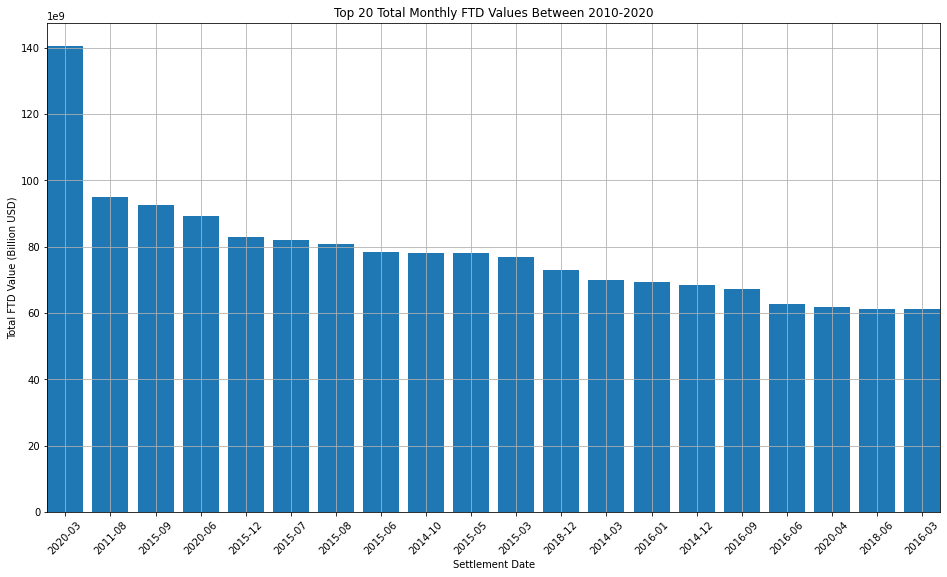

In [7]:
df1 = (df
       .groupby(by=pd.Grouper(key=COL_DATE, freq="M"))
       .agg({COL_TOTAL: sum})
       .reset_index()
       .sort_values(by=COL_TOTAL, ascending=False))

plt.figure(figsize=(16, 9))

TOP_N = 20
width = 0.8
x = list(range(TOP_N))
x_labels = [f"{date:%Y-%m}" for date in df1.head(TOP_N)[COL_DATE]]

plt.bar(x, df1.head(TOP_N)[COL_TOTAL], width=width, align="edge")
plt.xticks(ticks=[xtick + width / 2 for xtick in x], labels=x_labels, rotation=45)
plt.xlim(left=0, right=len(x) - (1 - width))
plt.ylim(bottom=0)
plt.ticklabel_format(axis="y", style="sci", scilimits=(9,9))
plt.grid(True)
plt.xlabel("Settlement Date")
plt.ylabel("Total FTD Value (Billion USD)")
plt.title(f"Top {TOP_N} Total Monthly FTD Values Between 2010-2020")
plt.savefig(f"res/Top_{TOP_N}_Total_Monthly_FTD_Values_Between_2010-2020.png", bbox_inches='tight', facecolor="white")
plt.show()

# Monthly Aggregations - SPY

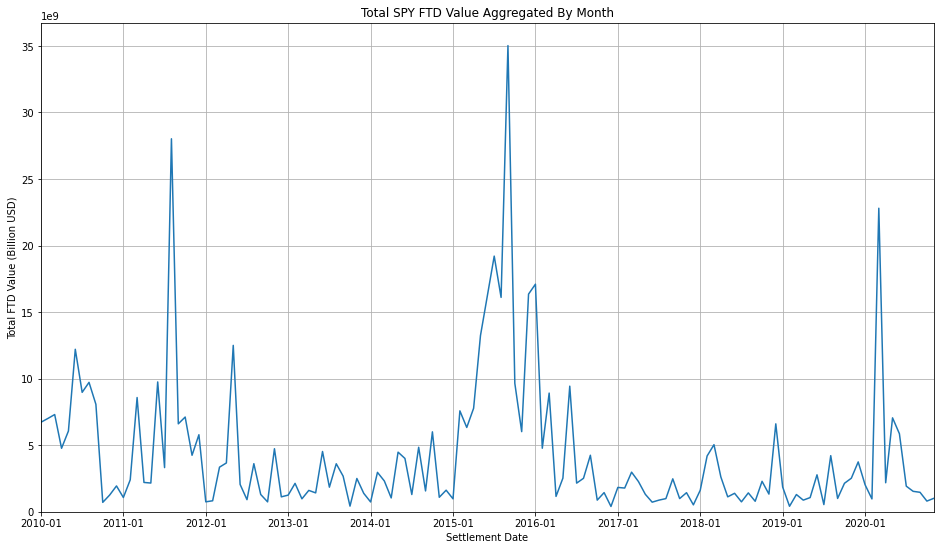

In [8]:
df1 = (df[df[COL_SYMBOL] == "SPY"]
       .groupby(by=pd.Grouper(key=COL_DATE, freq="M"))
       .agg({COL_TOTAL: sum})
       .reset_index())

plt.figure(figsize=(16, 9))

x = list(range(len(df1)))
x_labels = [f"{date:%Y-%m}" for idx, date in enumerate(df1[COL_DATE]) if idx % 12 == 0]
x_ticks = [x * 12 for x in list(range(len(x_labels)))]

plt.plot(x, df1[COL_TOTAL])
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.xlim(left=0, right=len(df1) - 1)
plt.ylim(bottom=0)
plt.ticklabel_format(axis="y", style="sci", scilimits=(9,9))
plt.grid(True)
plt.xlabel("Settlement Date")
plt.ylabel("Total FTD Value (Billion USD)")
plt.title("Total SPY FTD Value Aggregated By Month")
plt.savefig("res/Total_SPY_FTD_Value_Aggregated_By_Month.png", bbox_inches='tight', facecolor="white")
plt.show()

In [9]:
(df[df[COL_SYMBOL] == "SPY"]
 .groupby(by=pd.Grouper(key=COL_DATE, freq="M"))
 .agg({COL_TOTAL: sum})
 .reset_index()
 .sort_values(by=COL_TOTAL, ascending=False)
 .style
 .hide_index()
 .format({COL_DATE: "{:%Y-%m}", COL_TOTAL: "{:.2f}"})
 .bar(color="lightcoral", vmin=100_000, subset=[COL_TOTAL], align="left")
 .set_caption("Total SPY FTD Value By Month"))

SETTLEMENT DATE,TOTAL (USD)
2015-09,35020911803.51
2011-08,28021415713.76
2020-03,22803836886.20
2015-07,19207612428.53
2016-01,17099125729.56
2015-12,16353331836.96
2015-06,16241822511.39
2015-08,16106615131.32
2015-05,13242564413.20
2012-05,12502155824.60


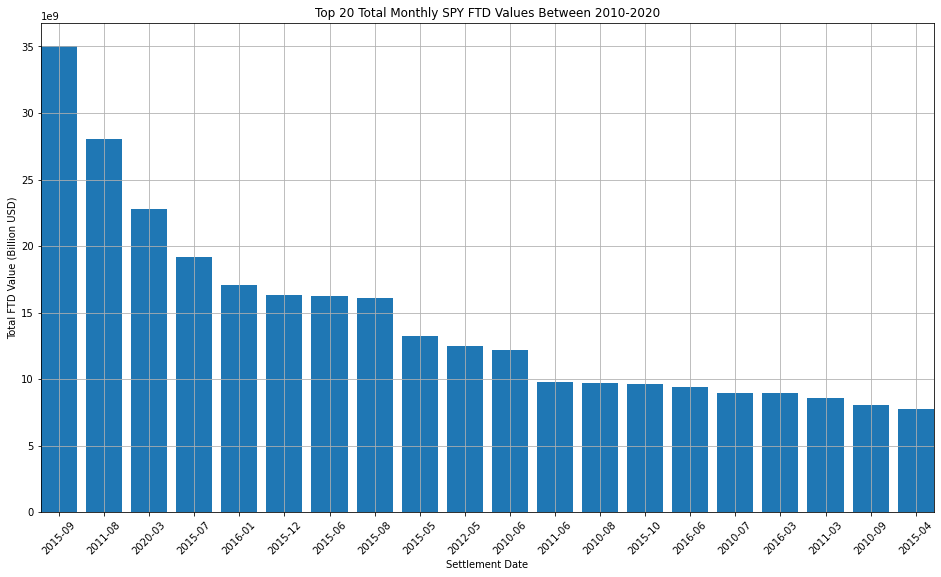

In [10]:
df1 = (df[df[COL_SYMBOL] == "SPY"]
       .groupby(by=pd.Grouper(key=COL_DATE, freq="M"))
       .agg({COL_TOTAL: sum})
       .reset_index()
       .sort_values(by=COL_TOTAL, ascending=False))

plt.figure(figsize=(16, 9))

TOP_N = 20
width = 0.8
x = list(range(TOP_N))

x_labels = [f"{date:%Y-%m}" for date in df1.head(TOP_N)[COL_DATE]]
plt.bar(x, df1.head(TOP_N)[COL_TOTAL], width=width, align="edge")
plt.xticks(ticks=[xtick + width / 2 for xtick in x], labels=x_labels, rotation=45)
plt.xlim(left=0, right=len(x) - (1 - width))
plt.ylim(bottom=0)
plt.ticklabel_format(axis="y", style="sci", scilimits=(9,9))
plt.grid(True)
plt.xlabel("Settlement Date")
plt.ylabel("Total FTD Value (Billion USD)")
plt.title(f"Top {TOP_N} Total Monthly SPY FTD Values Between 2010-2020")
plt.savefig(f"res/Top_{TOP_N}_Total_Monthly_SPY_FTD_Values_Between_2010-2020.png", bbox_inches='tight', facecolor="white")
plt.show()

# Yearly Aggregations

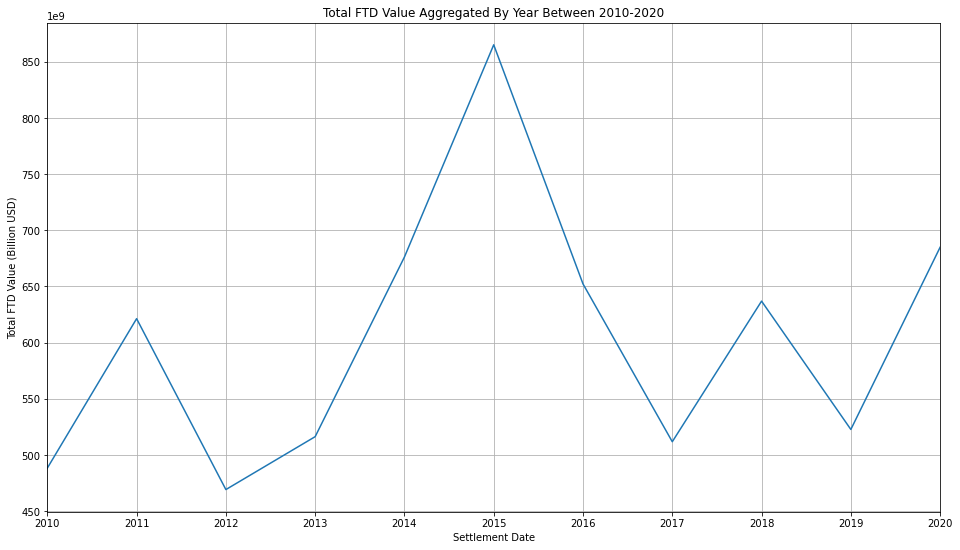

In [11]:
df1 = (df
       .groupby(by=pd.Grouper(key=COL_DATE, freq="Y"))
       .agg({COL_TOTAL: sum})
       .reset_index())

plt.figure(figsize=(16, 9))

x = list(range(len(df1)))
x_labels = [f"{date:%Y}" for date in df1[COL_DATE]]

plt.plot(x, df1[COL_TOTAL])
plt.xticks(ticks=x, labels=x_labels)
plt.xlim(left=0, right=len(df1) - 1)
# plt.ylim(bottom=0)
plt.ticklabel_format(axis="y", style="sci", scilimits=(9,9))
plt.grid(True)
plt.xlabel("Settlement Date")
plt.ylabel("Total FTD Value (Billion USD)")
plt.title("Total FTD Value Aggregated By Year Between 2010-2020")
plt.savefig("res/Total_FTD_Value_Aggregated_By_Year_Between_2010-2020.png", bbox_inches='tight', facecolor="white")
plt.show()

In [12]:
(df
 .groupby(by=pd.Grouper(key=COL_DATE, freq="Y"))
 .agg({COL_TOTAL: sum})
 .reset_index()
 .style
 .hide_index()
 .format({COL_DATE: "{:%Y}", COL_TOTAL: "{:.2f}"})
 .bar(color="lightcoral", vmin=100_000, subset=[COL_TOTAL], align="left")
 .set_caption("Total FTD Value By Year"))

SETTLEMENT DATE,TOTAL (USD)
2010,488343620379.00
2011,621322397949.50
2012,469246328320.90
2013,516320393192.57
2014,676202798037.79
2015,865021934110.83
2016,652233474110.38
2017,511809801642.42
2018,636936011815.15
2019,522730087455.91


# Total Aggregations

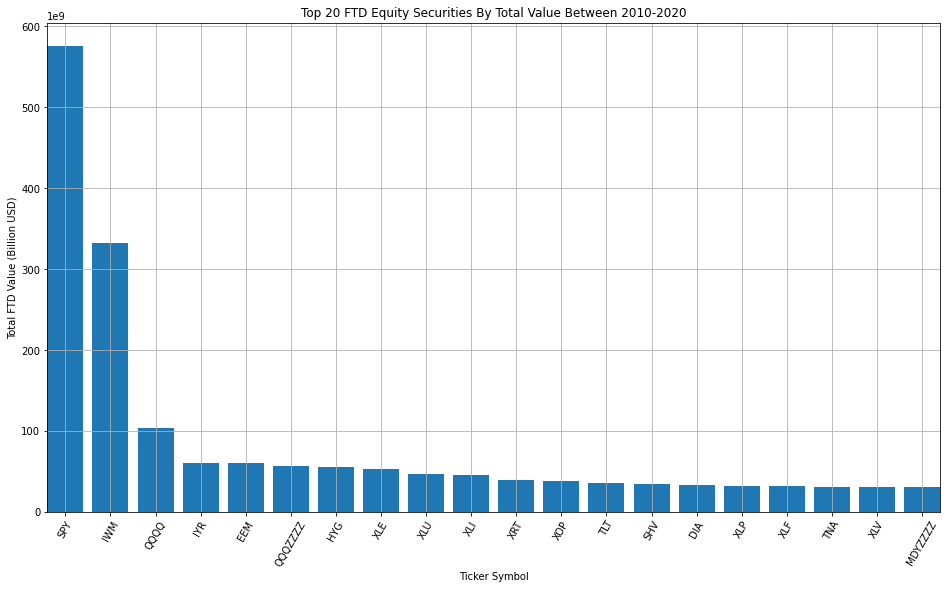

In [13]:
# Create the CUSIP to ticker symbol map
df_cusip_to_symbol = df[[COL_CUSIP, COL_SYMBOL]].drop_duplicates(subset=COL_CUSIP)
CUSIP_TO_SYMBOL = {key:val for (_, key, val) in df_cusip_to_symbol.itertuples()}
del df_cusip_to_symbol

df1 = (df
       .groupby(by=COL_CUSIP)
       .agg({COL_TOTAL: sum})
       .reset_index()
       .sort_values(by=COL_TOTAL, ascending=False))

# Add the ticker symbol column for plotting
df1[COL_SYMBOL] = df1.apply(lambda row: CUSIP_TO_SYMBOL[row[COL_CUSIP]], axis=1)

plt.figure(figsize=(16, 9))

TOP_N = 20
width = 0.8
x = list(range(TOP_N))

plt.bar(x, df1.head(TOP_N)[COL_TOTAL], width=width, align="edge")
plt.xticks([xtick + width / 2 for xtick in x], df1.head(TOP_N)[COL_SYMBOL], rotation=60)
plt.xlim(left=0, right=len(x) - (1 - width))
plt.ylim(bottom=0)
plt.ticklabel_format(axis="y", style="sci", scilimits=(9,9))
plt.grid(True)
plt.xlabel("Ticker Symbol")
plt.ylabel("Total FTD Value (Billion USD)")
plt.title(f"Top {TOP_N} FTD Equity Securities By Total Value Between 2010-2020")
plt.savefig(f"res/Top_{TOP_N}_FTD_Equity_Securities_By_Total_USD_Between_2010-2020.png", bbox_inches='tight', facecolor="white")
plt.show()